## Backtesting
### Estimación de Eventos en Velas de Precios
En este cuaderno estudiamos la ocurrencia del máximo y el mínimo en una vela de precios a partir de datos de menor resolución. Las características determinadas en este estudio nos pueden valer como estimación de la ocurrencia de dichos eventos cuando tenemos que
hacer suposiciones para simular órdenes limitadas 

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from mplfinance.original_flavor import candlestick2_ohlc
import mplfinance as mpf

In [3]:
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [4]:
ticker = 'REE'

In [5]:
stock_df = stock_data['REE'].loc['2010':]
stock_df.head()

,open,high,low,close,vol
2010-01-04,5.626898,5.663191,5.545601,5.547053,1952088
2010-01-05,5.545601,5.570280,5.531084,5.541246,1958264
2010-01-06,5.543424,5.548505,5.454142,5.490435,1471012
2010-01-07,5.502049,5.502049,5.409865,5.455594,4971592
2010-01-08,5.502049,5.531084,5.455594,5.506404,4281380


Hacemos un muestreo sobre la serie original para construir los datos OHLC en velas 
mensuales.  Estas velas mensuales las utilizaremos para caracterizar la ocurrencia 
de máximos y mínimos

In [6]:
open_m = stock_df.open.resample('1M').first()
close_m = stock_df.close.resample('1M').last()
high_m = stock_df.high.resample('1M').max()
low_m = stock_df.low.resample('1M').min()

In [7]:
close_m.head()

2010-01-31    5.265418
2010-02-28    5.365587
2010-03-31    5.768441
2010-04-30    5.161619
2010-05-31    4.675290
Freq: M, Name: close, dtype: float64

In [8]:
stock_month_df = pd.concat([open_m, high_m, low_m, close_m], axis=1)
stock_month_df.head()

,open,high,low,close
2010-01-31,5.626898,5.663191,5.262514,5.265418
2010-02-28,5.252352,5.525277,4.909744,5.365587
2010-03-31,5.401880,5.916518,5.327842,5.768441
2010-04-30,5.804009,5.912888,4.951844,5.161619
2010-05-31,5.178314,5.255981,4.371153,4.675290


____
Visualizamos las velas a diferente resolución

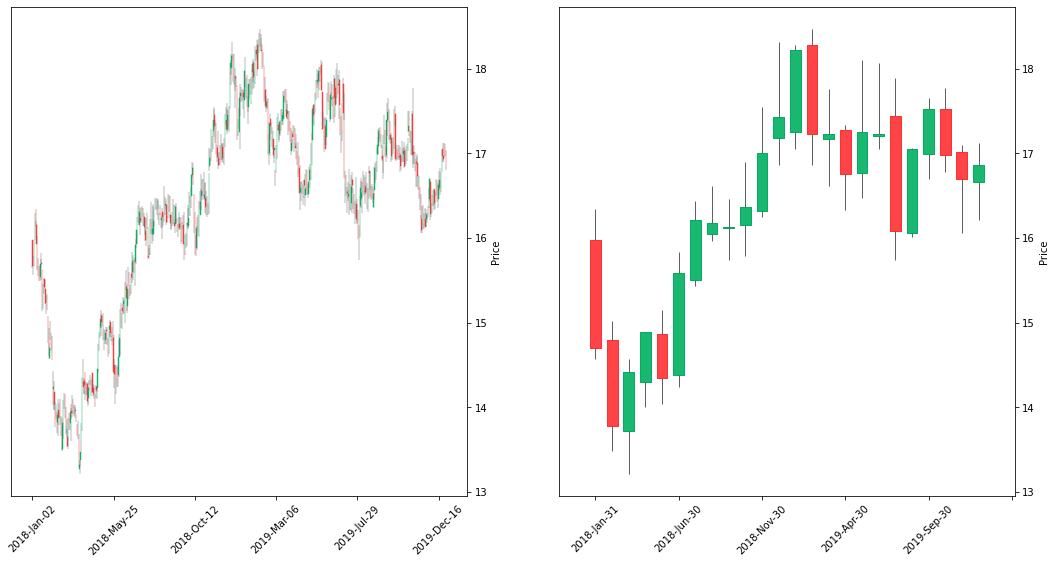

In [9]:
view_df = stock_df.loc['2018':'2019']
view_m_df = stock_month_df.loc['2018':'2019']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
mpf.plot(view_df, ax=ax1, type='candle', style='yahoo')
mpf.plot(view_m_df, ax=ax2, type='candle', style='yahoo')

____
Si vemos la primera vela mensual. ¿**Podemos determinar qué ocurre primero con datos de menor resolución**?

In [10]:
windata = view_df.loc[:'2018-01']

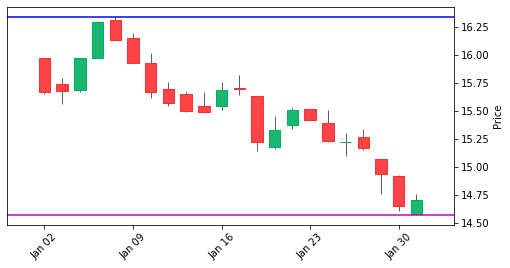

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(windata.high.max(), c='b')
ax.axhline(windata.low.min(), c='m')
mpf.plot(windata, ax=ax, type='candle', style='yahoo')

In [12]:
windata.high.max(), windata.high.idxmax()

(16.338810181, Timestamp('2018-01-08 00:00:00'))

In [13]:
windata.low.min(), windata.low.idxmin()

(14.57699279, Timestamp('2018-01-31 00:00:00'))

Para una ventana, bastaría determinar cual de los índices ocurre primero

___

In [14]:
def high_before_low(vseries):
    """ Funcion que """
    return vseries.idxmax() < vseries.idxmin()

In [15]:
stock_df.resample('1M').apply(high_before_low)

,open,high,low,close,vol
2010-01-31,True,True,True,True,True
2010-02-28,True,True,True,True,True
2010-03-31,False,False,False,False,True
2010-04-30,True,True,True,True,False
2010-05-31,True,True,True,True,True
...,...,...,...,...,...
2020-04-30,True,True,True,True,False
2020-05-31,False,False,False,False,False
2020-06-30,False,False,False,False,False
2020-07-31,False,False,False,True,True


In [16]:
month_high_before_low = stock_df.resample('1M').apply(high_before_low)['close']
month_high_before_low

2010-01-31     True
2010-02-28     True
2010-03-31    False
2010-04-30     True
2010-05-31     True
              ...  
2020-04-30     True
2020-05-31    False
2020-06-30    False
2020-07-31     True
2020-08-31    False
Freq: M, Name: close, Length: 128, dtype: bool

____
Si no supieramos la realidad y solo tendríamos la vela mensual, podríamos estimar 
la frecuencia de ocurrencia de los eventos tanto en velas verdes, como en velas rojas

In [17]:
stock_m_green_candle = stock_month_df.open < stock_month_df.close 
stock_m_green_candle.head(12)

2010-01-31    False
2010-02-28     True
2010-03-31     True
2010-04-30    False
2010-05-31    False
2010-06-30    False
2010-07-31     True
2010-08-31    False
2010-09-30     True
2010-10-31     True
2010-11-30    False
2010-12-31     True
Freq: M, dtype: bool

In [18]:
compare_candle = pd.concat([stock_m_green_candle, month_high_before_low], axis=1)
compare_candle.columns = ['GreenCandle', 'HighBeforeLow']

In [20]:
pd.crosstab(compare_candle.GreenCandle, compare_candle.HighBeforeLow)

HighBeforeLow,False,True
GreenCandle,,
False,6,47
True,69,6


_____
Proporción de **máximos antes que mínimos en velas verdes**

In [21]:
high_before_green = compare_candle.HighBeforeLow[compare_candle.GreenCandle == True]
high_before_green.value_counts()/high_before_green.shape[0]

False    0.92
True     0.08
Name: HighBeforeLow, dtype: float64

Proporción de **máximos antes que mínimos en velas rojas** 

In [22]:
high_before_red = compare_candle.HighBeforeLow[compare_candle.GreenCandle == False]
high_before_red.value_counts()/high_before_red.shape[0]

True     0.886792
False    0.113208
Name: HighBeforeLow, dtype: float64

Intentamos ver con mas detalle cuales serían las características de ambos casos

In [23]:
month_openclose_return = stock_month_df.close/stock_month_df.open - 1
month_openclose_return

2010-01-31   -0.064241
2010-02-28    0.021559
2010-03-31    0.067858
2010-04-30   -0.110680
2010-05-31   -0.097140
                ...   
2020-04-30   -0.000311
2020-05-31    0.002532
2020-06-30    0.087988
2020-07-31   -0.003318
2020-08-31   -0.016949
Freq: M, Length: 128, dtype: float64

C:\Users\trosa\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


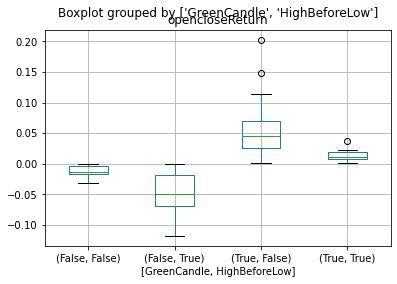

In [24]:
compare_candle['opencloseReturn'] = month_openclose_return
compare_candle.boxplot(column='opencloseReturn', by=['GreenCandle','HighBeforeLow'])

____

### Ejercicio Propuesto

1. Calcular el porcentaje del "evento máximo-antes-que-mínimo" para cada uno de las series OHLC mensuales
de los valores del IBEX35, diferenciando por meses de rentabilidad positiva (vela verde) y rentabilidad negativa (vela roja)

In [25]:
close_series = {ticker: df.close
                for ticker, df in stock_data.items()}
stock_df = pd.DataFrame(close_series)
stock_df = stock_df.loc['2010':]
stock_df = stock_df.dropna(how='all', axis=1)

In [28]:
def month_hbl(vseries):
    hbl = vseries.resample('1M').apply(high_before_low)
    return hbl

In [29]:
stock_df.apply(month_hbl)

,SAN,BTO_1,BKIA_0,BKIA,NTGY,TRE,ACX_0,ACX,FER,ACS,...,MEL,TL5,REE,COL,JAZ,TEF,FCC,CABK,DIA,ALM
2010-01-31,True,True,False,False,True,True,True,False,True,True,...,False,False,True,False,False,True,True,False,False,False
2010-02-28,True,True,False,False,True,False,True,False,True,True,...,False,True,True,False,False,False,True,False,False,False
2010-03-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2010-04-30,True,True,False,False,True,True,False,False,True,True,...,False,True,True,False,False,True,True,False,False,False
2010-05-31,False,True,False,False,True,True,True,False,True,True,...,False,True,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,True,False,False,True,True,False,False,False,False,False,...,False,False,True,True,False,True,False,True,False,False
2020-05-31,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2020-06-30,False,False,False,False,True,False,False,True,True,True,...,True,True,False,True,False,True,False,False,False,True
2020-07-31,True,False,False,False,True,False,False,False,True,True,...,True,False,True,True,False,True,False,True,False,True


In [ ]:
month_high_before_low = stock_df.resample('1M').apply(high_before_low)['close']